In [5]:
import torch

A = torch.randn(3, 3, dtype=torch.float64)
L, V = torch.linalg.eig(A)

print(L)
print(V)

print(L.shape)
print(V.shape)


tensor([ 1.6366+0.j,  0.6081+0.j, -1.6731+0.j], dtype=torch.complex128)
tensor([[-0.0211+0.j,  0.5899+0.j, -0.6193+0.j],
        [-0.1415+0.j, -0.3284+0.j, -0.7554+0.j],
        [ 0.9897+0.j,  0.7377+0.j, -0.2141+0.j]], dtype=torch.complex128)
torch.Size([3])
torch.Size([3, 3])


In [2]:
import numpy as np


def fancy_pca(img, alpha_std=0.1):
    '''
    INPUTS:
    img:  numpy array with (h, w, rgb) shape, as ints between 0-255)
    alpha_std:  how much to perturb/scale the eigen vecs and vals
                the paper used std=0.1

    RETURNS:
    numpy image-like array as float range(0, 1)
    '''

    orig_img = img.astype(float).copy()

    img = img / 255.0  # rescale to 0 to 1 range

    # flatten image to columns of RGB
    img_rs = img.reshape(-1, 3)
    # img_rs shape (640000, 3)

    # center mean
    img_centered = img_rs - np.mean(img_rs, axis=0)

    # paper says 3x3 covariance matrix
    img_cov = np.cov(img_centered, rowvar=False)

    # eigen values and eigen vectors
    eig_vals, eig_vecs = np.linalg.eigh(img_cov)

#     eig_vals [0.00154689 0.00448816 0.18438678]

#     eig_vecs [[ 0.35799106 -0.74045435 -0.56883192]
#      [-0.81323938  0.05207541 -0.57959456]
#      [ 0.45878547  0.67008619 -0.58352411]]

    # sort values and vector
    sort_perm = eig_vals[::-1].argsort()
    eig_vals[::-1].sort()
    eig_vecs = eig_vecs[:, sort_perm]

    # get [p1, p2, p3]
    m1 = np.column_stack((eig_vecs))

    # get 3x1 matrix of eigen values multiplied by random variable draw from normal
    # distribution with mean of 0 and standard deviation of 0.1
    m2 = np.zeros((3, 1))
    # according to the paper alpha should only be draw once per augmentation (not once per channel)
    alpha = np.random.normal(0, alpha_std)

    # broad cast to speed things up
    m2[:, 0] = alpha * eig_vals[:]

    # this is the vector that we're going to add to each pixel in a moment
    add_vect = np.matrix(m1) * np.matrix(m2)

    for idx in range(3):   # RGB
        orig_img[..., idx] += add_vect[idx]

    # for image processing it was found that working with float 0.0 to 1.0
    # was easier than integers between 0-255
    # orig_img /= 255.0
    orig_img = np.clip(orig_img, 0.0, 255.0)

    # orig_img *= 255
    orig_img = orig_img.astype(np.uint8)

    # about 100x faster after vectorizing the numpy, it will be even faster later
    # since currently it's working on full size images and not small, square
    # images that will be fed in later as part of the post processing before being
    # sent into the model
#     print("elapsed time: {:2.2f}".format(time.time() - start_time), "\n")

    return orig_img

(1440, 1440, 3)
(1440, 1440, 3)


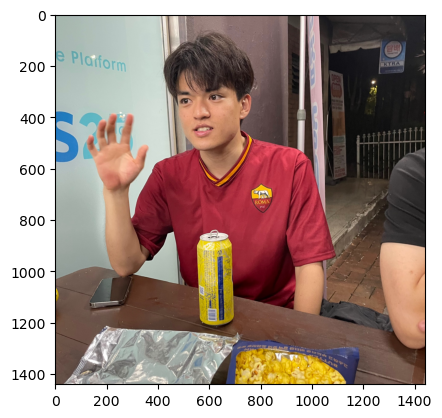

In [5]:
from PIL import Image
import numpy
from matplotlib import pyplot as plt
 
img= Image.open("./test_pca.jpeg")
np_img = numpy.array(img)
pca_img = fancy_pca(np_img)

print(np_img.shape)
print(pca_img.shape)

plt.imshow(np_img)
plt.imshow(pca_img, cmap='hot')